In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_path = 'data' 

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
learning_rates = [0.001, 0.005]
num_epochs_list = [5, 10]
batch_sizes = [16, 32]

best_lr = 0
best_batch_size = 0
best_epochs = 0
best_accuracy = 0.0
best_model = None

for lr in learning_rates:
    for num_epochs in num_epochs_list:
        for bs in batch_sizes:
            model = models.resnet18()

            num_classes = 2
            model.fc = nn.Linear(model.fc.in_features, num_classes)

            model.train()

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

            print(f"\nHyperparameters: Learning Rate={lr}, Epochs={num_epochs}, Batch Size={bs}")
            
            for epoch in range(num_epochs):
                for i, data in enumerate(train_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs, labels
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            model.eval()
            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs, labels
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    predictions.extend(predicted.cpu().numpy())
                    true_labels.extend(labels.cpu().numpy())

            accuracy = accuracy_score(true_labels, predictions)
            print(f"Test Accuracy: {accuracy * 100:.2f}%")

            # Check if current hyperparameters are the best
            if accuracy > best_accuracy:
                best_lr = lr
                best_batch_size = bs
                best_epochs = num_epochs
                best_accuracy = accuracy
                best_model = model.state_dict()

print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_lr}, Epochs: {best_epochs}, Batch Size: {best_batch_size}")
torch.save(best_model, 'best_transfer_learning_model.pth')



Hyperparameters: Learning Rate=0.001, Epochs=5, Batch Size=16
Test Accuracy: 97.75%

Hyperparameters: Learning Rate=0.001, Epochs=5, Batch Size=32
Test Accuracy: 51.75%

Hyperparameters: Learning Rate=0.001, Epochs=10, Batch Size=16
Test Accuracy: 98.12%

Hyperparameters: Learning Rate=0.001, Epochs=10, Batch Size=32
Test Accuracy: 89.00%

Hyperparameters: Learning Rate=0.005, Epochs=5, Batch Size=16
Test Accuracy: 51.75%

Hyperparameters: Learning Rate=0.005, Epochs=5, Batch Size=32
Test Accuracy: 89.38%

Hyperparameters: Learning Rate=0.005, Epochs=10, Batch Size=16
Test Accuracy: 98.75%

Hyperparameters: Learning Rate=0.005, Epochs=10, Batch Size=32
Test Accuracy: 58.25%

Best Hyperparameters:
Learning Rate: 0.005, Epochs: 10, Batch Size: 16
Training process took 2979.7763278484344


[Epoch 1, Batch 10] Loss: 2.120
[Epoch 1, Batch 20] Loss: 0.754
[Epoch 1, Batch 30] Loss: 0.690
[Epoch 1, Batch 40] Loss: 0.799
[Epoch 1, Batch 50] Loss: 0.923
[Epoch 1, Batch 60] Loss: 0.758
[Epoch 1, Batch 70] Loss: 0.804
[Epoch 1, Batch 80] Loss: 0.746
[Epoch 1, Batch 90] Loss: 0.690
[Epoch 1, Batch 100] Loss: 0.825
[Epoch 1, Batch 110] Loss: 0.841
[Epoch 1, Batch 120] Loss: 0.761
[Epoch 1, Batch 130] Loss: 0.776
[Epoch 1, Batch 140] Loss: 0.791
[Epoch 1, Batch 150] Loss: 0.662
[Epoch 1, Batch 160] Loss: 0.736
[Epoch 1, Batch 170] Loss: 0.786
[Epoch 1, Batch 180] Loss: 0.693
[Epoch 1, Batch 190] Loss: 0.646
[Epoch 1, Batch 200] Loss: 0.659
[Epoch 2, Batch 10] Loss: 0.686
[Epoch 2, Batch 20] Loss: 0.703
[Epoch 2, Batch 30] Loss: 0.669
[Epoch 2, Batch 40] Loss: 0.627
[Epoch 2, Batch 50] Loss: 0.614
[Epoch 2, Batch 60] Loss: 0.623
[Epoch 2, Batch 70] Loss: 0.691
[Epoch 2, Batch 80] Loss: 0.669
[Epoch 2, Batch 90] Loss: 0.670
[Epoch 2, Batch 100] Loss: 0.755
[Epoch 2, Batch 110] Loss: 0

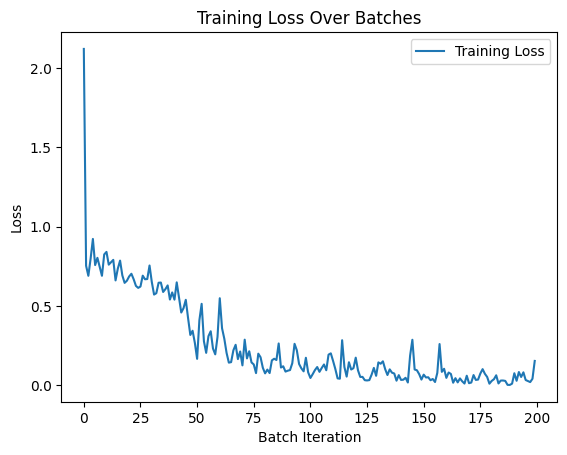

In [5]:
import matplotlib.pyplot as plt

loss_values = []

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
model = models.resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

model.train()

for epoch in range(best_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 9:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.3f}")
            loss_values.append(running_loss / 10)  # Record the loss value for plotting
            running_loss = 0.0

plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Over Batches')
plt.xlabel('Batch Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()